<a href="https://colab.research.google.com/github/rockaguirre/Neuro-140-Project/blob/main/neuro140_final_project_raguirre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageEnhance

In [9]:
train_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training'
test_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing'

In [10]:
classifications = ['notumor', 'glioma','meningioma', 'pituitary']

data_train = []
classifications_train = []
data_test = []
classifications_test = []

In [11]:
image_size = 128

for label in classifications:
  path = os.path.join(train_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_train.append(image)
      classifications_train.append(label)

for label in classifications:
  path = os.path.join(test_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_test.append(image)
      classifications_test.append(label)

data_train = np.array(data_train)
classifications_train = np.array(classifications_train)
data_test = np.array(data_test)
classifications_test = np.array(classifications_test)

In [12]:
data_train.shape

(5712, 128, 128, 3)

In [13]:
data_test.shape

(1311, 128, 128, 3)

In [14]:
data_train, classifications_train = shuffle(data_train, classifications_train, random_state=30)

In [15]:
# ensure shape is the same
data_train.shape

(5712, 128, 128, 3)

In [16]:
data_test.shape

(1311, 128, 128, 3)

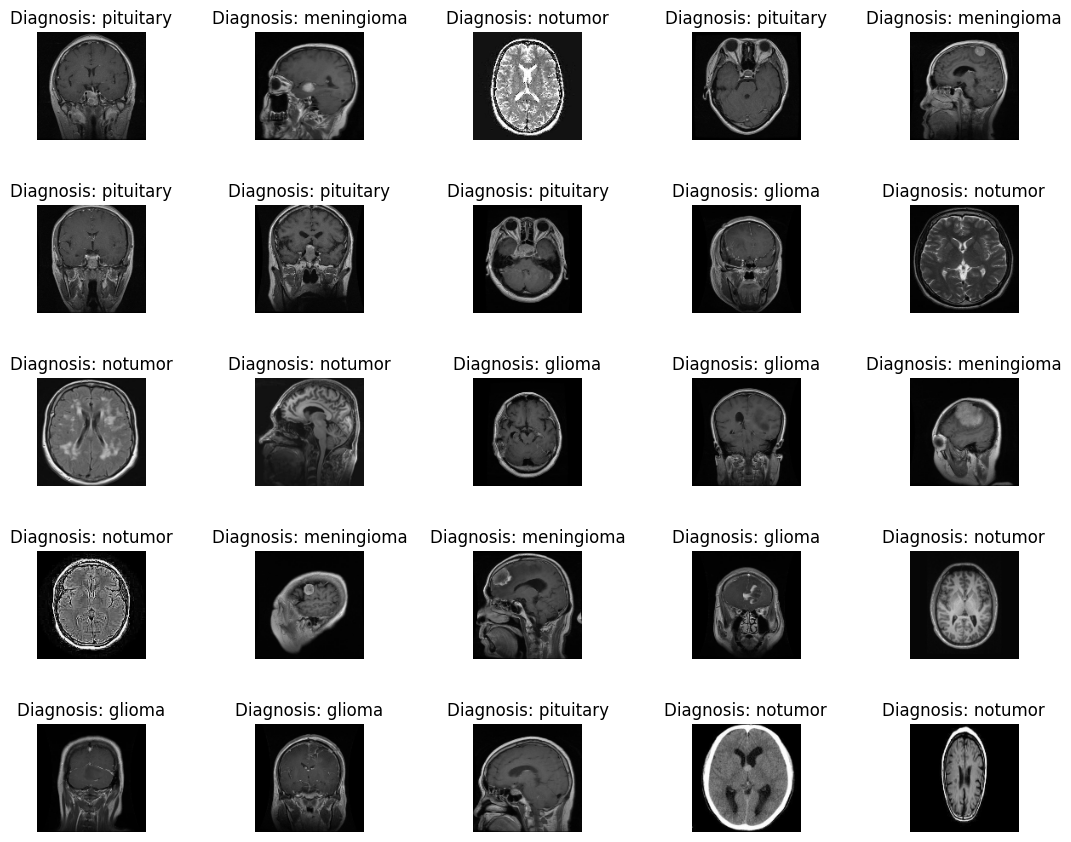

In [17]:
grid_width = 5
grid_height = 5

figure, axis = plt.subplots(grid_width, grid_height, figsize=(8,8))

img_idx = 0

for x in range(grid_width):
    for y in range(grid_height):
        axis[x][y].axis('off')
        axis[x][y].set_title('Diagnosis: '+ classifications_train[img_idx])
        axis[x][y].imshow(data_train[img_idx])
        img_idx += 1

# fix orientation and overlap of titles
plt.subplots_adjust(left=0, bottom=0, right=1.3, top=1, wspace=0.3, hspace=0.6)

In [18]:
# split dataset into train, test, and validation
data_train, data_test, classifications_train, classifications_test = train_test_split(data_train, classifications_train, test_size = 0.15, random_state=30)
data_train, data_validation, classifications_train, classifications_validation = train_test_split(data_train, classifications_train, test_size = 0.2, random_state=30)

In [19]:
classifications_train_updated = []
classifications_validation_updated = []
classifications_test_updated = []

# turn classifications like "glioma" into values
for label in classifications_train:
    classifications_train_updated.append(classifications.index(label))

# to_categorical to turn into a one hot encoded representation -- do not %100 understand but it helped fix a problem -- chatGPT told me to try
classifications_train = to_categorical(classifications_train_updated)

for label in classifications_validation:
    classifications_validation_updated.append(classifications.index(label))

classifications_validation = to_categorical(classifications_validation_updated)


for label in classifications_test:
    classifications_test_updated.append(classifications.index(label))

classifications_test = to_categorical(classifications_test_updated)


In [20]:
classifications_train

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
"""
def enhance_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0

  return image
  """

In [ ]:
"""
unique_classification = os.listdir(train_directory)

def encode_classification(classifications):
  return np.array([unique_classification.index(x) for x in classifications])

def decode_classification(classifications):
  return np.array([unique_classification[x] for x in classifications])

def datagen(paths, classifications, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i, (path, classification) in enumerate(zip(paths, classifications)):
      if i % batch_size == 0:
          batch_images = transform_images(paths[i:i+batch_size])
          batch_classifications = encode_classification(classifications[i:i+batch_size])
          yield batch_images, batch_classifications
"""

In [13]:
general_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
general_model.layers[-2].trainable=True
general_model.layers[-3].trainable=True
general_model.layers[-4].trainable=True

# first CNN model
first_model = Sequential()
first_model.add(Input(shape=(image_size,image_size,3)))
first_model.add(general_model)
first_model.add(Flatten())
first_model.add(Dropout(0.2))
first_model.add(Dense(units=128, activation='relu'))
first_model.add(Dropout(0.2))
first_model.add(Dense(units=4, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [15]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
first_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [21]:
# scale data to match array type float32

scale_data_train = data_train.astype('float32')
scale_data_test = data_test.astype('float32')
scale_data_validation = data_validation.astype('float32')

scale_data_train /= 255
scale_data_test /= 255
scale_data_validation /= 255

In [16]:
batch_size = 32
epochs = 10

history = first_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
150/150 [==============================] - 1331s 9s/step - loss: 1.2663 - Accuracy: 0.3929 - val_loss: 1.0639 - val_Accuracy: 0.5017
Epoch 2/10
150/150 [==============================] - 1328s 9s/step - loss: 1.0139 - Accuracy: 0.4928 - val_loss: 0.9828 - val_Accuracy: 0.5075
Epoch 3/10
150/150 [==============================] - 1287s 9s/step - loss: 0.9687 - Accuracy: 0.4965 - val_loss: 0.9356 - val_Accuracy: 0.5209
Epoch 4/10
150/150 [==============================] - 1269s 8s/step - loss: 0.7983 - Accuracy: 0.6216 - val_loss: 0.5287 - val_Accuracy: 0.7848
Epoch 5/10
150/150 [==============================] - 1313s 9s/step - loss: 0.4722 - Accuracy: 0.8157 - val_loss: 0.3595 - val_Accuracy: 0.8509
Epoch 6/10
150/150 [==============================] - 1313s 9s/step - loss: 0.3262 - Accuracy: 0.8773 - val_loss: 0.3821 - val_Accuracy: 0.8610
Epoch 7/10
150/150 [==============================] - 1305s 9s/step - loss: 0.2760 - Accuracy: 0.9009 - val_loss: 0.3508 - val_Accuracy:

In [18]:
test_loss, test_accuracy = first_model.evaluate(data_test, classifications_test, batch_size=batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 189s 6s/step - loss: 673.1811 - Accuracy: 0.3548
Test Loss: 673.1810913085938
Test Accuracy: 0.35483869910240173


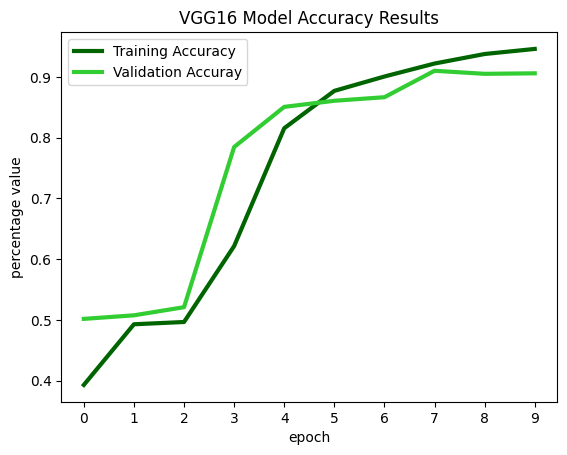

In [19]:
plt.plot(history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('VGG16 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

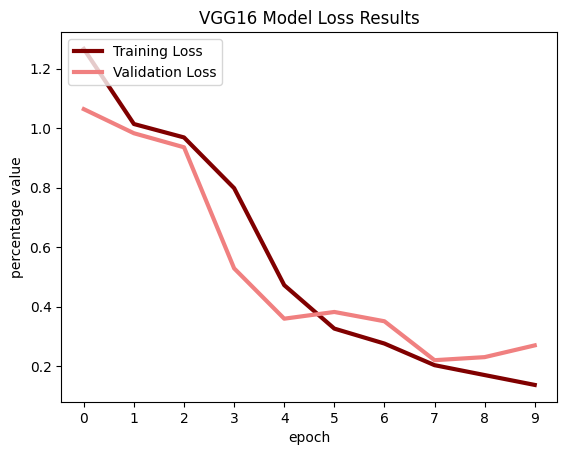

In [20]:
plt.plot(history.history['loss'], 'maroon', linewidth=3)
plt.plot(history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('VGG16 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [17]:
second_general_model = ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in second_general_model.layers[:-4]:
    layer.trainable = False
for layer in second_general_model.layers[-4:]:
    layer.trainable = True

# first CNN model
second_model = Sequential()
second_model.add(Input(shape=(image_size,image_size,3)))
second_model.add(second_general_model)
second_model.add(Flatten())
second_model.add(Dropout(0.2))
second_model.add(Dense(units=128, activation='relu'))
second_model.add(Dropout(0.2))
second_model.add(Dense(units=4, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
second_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [16]:
batch_size = 32
epochs = 10
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=2)
second_history = second_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[lr_scheduler],
                          verbose=1)

Epoch 1/10
150/150 [==============================] - 370s 2s/step - loss: 0.9302 - Accuracy: 0.6559 - val_loss: 0.7967 - val_Accuracy: 0.7529 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - 355s 2s/step - loss: 0.6362 - Accuracy: 0.7349 - val_loss: 0.7231 - val_Accuracy: 0.6792 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - 353s 2s/step - loss: 0.5678 - Accuracy: 0.7698 - val_loss: 0.5363 - val_Accuracy: 0.7864 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - 342s 2s/step - loss: 0.5235 - Accuracy: 0.7841 - val_loss: 1.1512 - val_Accuracy: 0.6089 - lr: 0.0010
Epoch 5/10
150/150 [==============================] - 359s 2s/step - loss: 0.5212 - Accuracy: 0.7946 - val_loss: 1.3705 - val_Accuracy: 0.5486 - lr: 0.0010
Epoch 6/10
150/150 [==============================] - 357s 2s/step - loss: 0.4331 - Accuracy: 0.8258 - val_loss: 0.4671 - val_Accuracy: 0.8032 - lr: 5.0000e-04
Epoch 7/10
150/150 [==============================] - 352s 2

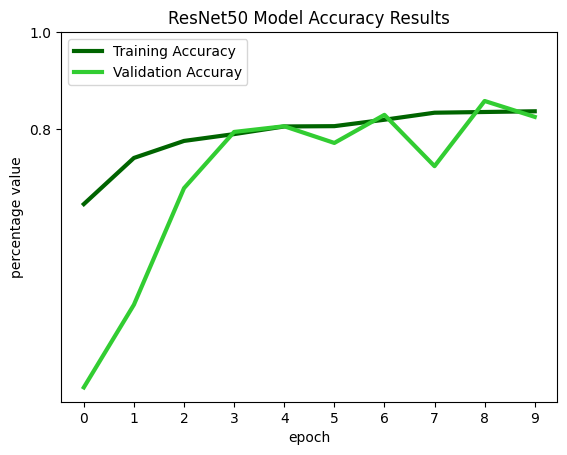

In [19]:
plt.plot(second_history.history['accuracy'], 'darkgreen', linewidth=3)
plt.plot(second_history.history['val_accuracy'], 'limegreen', linewidth=3)
plt.title('ResNet50 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.yticks([0.8,1])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

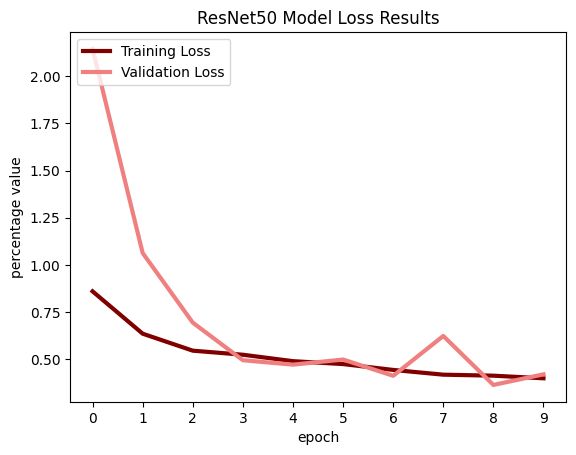

In [20]:
plt.plot(second_history.history['loss'], 'maroon', linewidth=3)
plt.plot(second_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('ResNet50 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [21]:
test_loss, test_accuracy = second_model.evaluate(data_test, classifications_test, batch_size=batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 61s 2s/step - loss: 27.7817 - accuracy: 0.2865
Test Loss: 27.781688690185547
Test Accuracy: 0.28652751445770264


In [22]:
third_model = Sequential()

third_model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size, 3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=128, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Flatten())
third_model.add(Dense(512, activation='relu'))
third_model.add(Dense(4, activation='softmax'))

In [23]:
third_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [24]:
batch_size = 32
epochs = 10

third_history = third_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
122/122 [==============================] - 154s 1s/step - loss: 0.7041 - Accuracy: 0.7078 - val_loss: 0.6061 - val_Accuracy: 0.7281
Epoch 2/10
122/122 [==============================] - 154s 1s/step - loss: 0.3743 - Accuracy: 0.8502 - val_loss: 0.4196 - val_Accuracy: 0.8517
Epoch 3/10
122/122 [==============================] - 153s 1s/step - loss: 0.2235 - Accuracy: 0.9122 - val_loss: 0.2895 - val_Accuracy: 0.9114
Epoch 4/10
122/122 [==============================] - 154s 1s/step - loss: 0.1407 - Accuracy: 0.9490 - val_loss: 0.2888 - val_Accuracy: 0.9083
Epoch 5/10
122/122 [==============================] - 151s 1s/step - loss: 0.0845 - Accuracy: 0.9683 - val_loss: 0.2988 - val_Accuracy: 0.9197
Epoch 6/10
122/122 [==============================] - 153s 1s/step - loss: 0.0719 - Accuracy: 0.9732 - val_loss: 0.2930 - val_Accuracy: 0.9382
Epoch 7/10
122/122 [==============================] - 153s 1s/step - loss: 0.0442 - Accuracy: 0.9833 - val_loss: 0.2918 - val_Accuracy: 0.9372

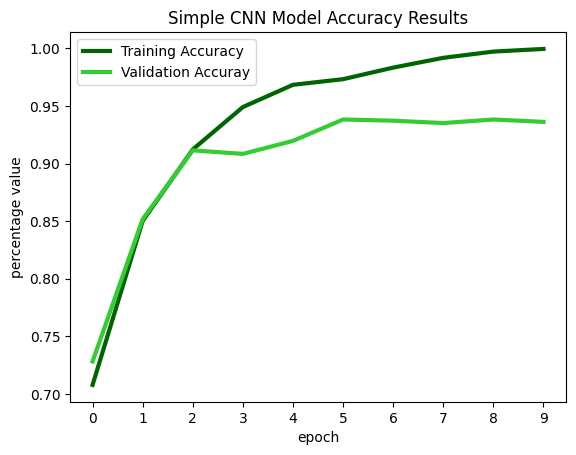

In [25]:
plt.plot(third_history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(third_history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('Simple CNN Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

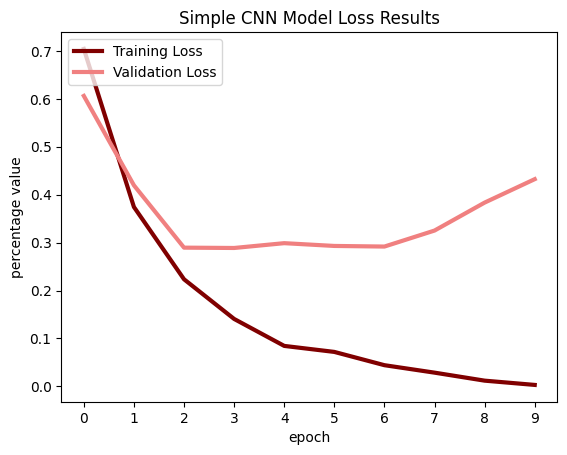

In [26]:
plt.plot(third_history.history['loss'], 'maroon', linewidth=3)
plt.plot(third_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('Simple CNN Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [27]:
predict_test = third_model.predict(scale_data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

27/27 [==============================] - 11s 390ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       217
           1       0.95      0.93      0.94       212
           2       0.90      0.89      0.89       199
           3       0.96      0.99      0.97       229

    accuracy                           0.95       857
   macro avg       0.94      0.94      0.94       857
weighted avg       0.94      0.95      0.95       857

